In [2]:
"""
Load reduced aquisition Gaussian processes inverse models and 
evaluate on experimental MRI data. 

Note: full models require approx 200 Gb of RAM for each model. 

Created by N Naughton on August 4, 2019
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import chaospy as cp
from SALib.sample import saltelli
from SALib.analyze import sobol
        
problem = {
            'num_vars': 7,
    
            'names': ['diameter', 
                      'packing', 
                      'perm', 
                      'Din', 
                      'Dex', 
                      'b-value',
                      'diff_time'],
    
            'bounds': [[10e-6, 80e-6 ], # diameter
                      [0.70  , 0.95  ], # volume fraction
                      [10e-6 , 100e-6], # permeability
                      [0.5e-9, 2.5e-9], # Din
                      [0.5e-9, 2.5e-9], # Dex
                      [300e6, 1200e6],  # b-value
                      [0.0100, 0.750]], # Diffusion Time

            'names_clean': ['Diameter', 
                            'Volume\nFraction', 
                            'Permeability', 
                            'Intracellular\nDiffusion', 
                            'Extracellular\nDiffusion', 
                            'B-Value',
                            'Diffusion\nTime']
            }

In [3]:
from sample import sample

meta_model = {}
order = '7_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']] =  pickle.load( open('../pickled_metamodels_7_new_new.pkl', 'rb'), encoding='latin1')[0]

 
mm_full = {your_key: meta_model[order][your_key] for your_key in ['FA','RD','L1']}
b_range = np.array([400e6, 800e6, 1000e6, 600e6, 800e6, 600e6, 1000e6, 400e6, 1000e6, 600e6])*1e-7
diff_range = np.array([700, 400, 50, 50, 200, 400, 700, 200, 400, 700])*1e-1

# Create dictonary for each pulse profile that will be used in inversion
mm = {}
for pulse_param, (b,delta) in enumerate(zip(b_range,diff_range)):
    mm[pulse_param] = {}
    print(pulse_param,'-',b*10,delta*10)
    for key in mm_full.keys():
        mm[pulse_param][key] = mm_full[key](np.ma.masked,np.ma.masked,np.ma.masked,np.ma.masked,np.ma.masked,b,delta)
        
problem_train = {'num_vars': 5,   
            'bounds': [[10e-6, 80e-6 ], # diameter
                      [0.70  , 0.95  ], # volume fraction
                      [10e-6 , 100e-6], # permeability
                      [0.5e-9, 2.5e-9], # Din
                      [0.5e-9, 2.5e-9]] # Dex
                       }
training_points = 750
param_values = sample(problem_train, training_points)

# ############################################
inputs_unscaled = param_values
input_scaled = inputs_unscaled*[1e6,1e2,1e6,1e10,1e10]
inputs = input_scaled.T

df_mm_train = pd.DataFrame(data = inputs.T, columns = problem['names'][:5])
for pulse_param, (b,delta) in enumerate(zip(b_range,diff_range)):
    print('starting',pulse_param,'-',b*10,delta*10)
    for key in mm_full.keys():
        df_mm_train['%s_%s_%s' % (int(b*10), int(delta*10),key)] = mm[pulse_param][key](inputs[0],inputs[1],inputs[2],inputs[3],inputs[4])

            


0 - 400.0 700.0
1 - 800.0 400.0
2 - 1000.0 50.0
3 - 600.0 50.0
4 - 800.0 200.0
5 - 600.0 400.0
6 - 1000.0 700.0
7 - 400.0 200.0
8 - 1000.0 400.0
9 - 600.0 700.0
starting 0 - 400.0 700.0
starting 1 - 800.0 400.0
starting 2 - 1000.0 50.0
starting 3 - 600.0 50.0
starting 4 - 800.0 200.0
starting 5 - 600.0 400.0
starting 6 - 1000.0 700.0
starting 7 - 400.0 200.0
starting 8 - 1000.0 400.0
starting 9 - 600.0 700.0


In [4]:
import dipy
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import nibabel as nib
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa

import pandas as pd
all_data = {}

num = [70, 76,82,88,94,101,107,113,119,125]

b =    [1000,600,800,400,800,600,1000,400,1000,600]
diff = [50,50,200,200,400,400,400,700,700,700]

for i, n in enumerate(num):
    fdwi = 'MRI_data/production_ep2d_advdiff_919D_20191009201519_%s.nii' % n
    fbval = 'MRI_data/production_ep2d_advdiff_919D_20191009201519_%s.bval' % n
    fbvec = 'MRI_data/production_ep2d_advdiff_919D_20191009201519_%s.bvec' % n


    img = nib.load(fdwi)
    data = img.get_data()

    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    S0s = data[:, :, :, gtab.b0s_mask]

    maskdata, mask = median_otsu(data, vol_idx=[0], median_radius=3,
                             numpass=1, autocrop=False, dilate=1)
    print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(data)
    
    v1 = tenfit.evecs[:,:,:,:,0]
    v2 = tenfit.evecs[:,:,:,:,1]
    v3 = tenfit.evecs[:,:,:,:,2]

    l1 = tenfit.evals[:,:,:,0]
    l2 = tenfit.evals[:,:,:,1]
    l3 = tenfit.evals[:,:,:,2]

    FA = fractional_anisotropy(tenfit.evals)
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    
    key = '%s_%s' % (b[i], diff[i])
    all_data[key] = {}
    all_data[key] = {'L1' : l1*1e3,
                  'L2' : l2*1e3,
                  'L3' : l3*1e3,
                  'FA' : FA,
                  'v1' : v1,
                  'v2' : v2,
                  'v3' : v3}
    
    
pts = all_data.keys()
metrics = ['L1','L2','L3','FA']
df_test = pd.DataFrame(data = [])

for p in pts:
    for m in metrics:
        if m == 'L3':
            df_test['%s_RD' % (p)] = all_data[p][m].flatten()
        else:
            df_test['%s_%s' % (p,m)] = all_data[p][m].flatten()
        
df_test = df_test[['400_700_FA', '400_700_RD','400_700_L1', '800_400_FA', '800_400_RD', '800_400_L1', '1000_50_FA','1000_50_RD', 
         '1000_50_L1', '600_50_FA', '600_50_RD', '600_50_L1','800_200_FA', '800_200_RD', '800_200_L1', '600_400_FA', 
         '600_400_RD','600_400_L1', '1000_700_FA', '1000_700_RD', '1000_700_L1', '400_200_FA','400_200_RD', '400_200_L1', 
         '1000_400_FA', '1000_400_RD', '1000_400_L1','600_700_FA', '600_700_RD', '600_700_L1']]

/tmp/ipykernel_2081679/1839461595.py:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)
maskdata.shape (64, 64, 20, 26)


In [6]:
from sklearn import preprocessing as pre

output_scaler = pre.MinMaxScaler(feature_range=(-1, 1))
outputs_inverse = df_mm_train.values[:,:5] 
output_train = output_scaler.fit_transform(outputs_inverse)

input_scaler  = pre.StandardScaler()
inputs_inverse  = df_mm_train.values[:,5:]
inputs_MEASURED = df_test.values


In [7]:
import numpy as np
from sklearn.decomposition import PCA

input_mean = inputs_inverse.mean(axis=0)
DNR = 30
DNR_sigma_train = input_mean/DNR
noiseDNR_1 = np.random.randn(inputs_inverse.shape[0],inputs_inverse.shape[1])*DNR_sigma_train
noiseDNR_2 = np.random.randn(inputs_inverse.shape[0],inputs_inverse.shape[1])*DNR_sigma_train
noiseDNR_3 = np.random.randn(inputs_inverse.shape[0],inputs_inverse.shape[1])*DNR_sigma_train


inputs_all = np.concatenate((inputs_inverse, 
                             inputs_inverse+noiseDNR_1, 
                             inputs_inverse+noiseDNR_2, 
                             inputs_inverse+noiseDNR_3))
## At this point there are two sets of data. 
# input_inverse which is noisefree and inputs_all which has noise added
pca = PCA()
## Perfrom PCA on noisefree data
pca.fit(inputs_inverse)
print(pca.explained_variance_ratio_) 

inputs_train_noisefree_pca = pca.transform(inputs_inverse)
inputs_train_pca = pca.transform(inputs_all)

inputs_train_scaled_noisefree_pca = input_scaler.fit_transform(inputs_train_noisefree_pca)
inputs_train_scaled_pca = input_scaler.transform(inputs_train_pca)

SNR_train = 0.02
noiseout1 = np.random.randn(output_train.shape[0],output_train.shape[1])*SNR_train
noiseout2 = np.random.randn(output_train.shape[0],output_train.shape[1])*SNR_train
noiseout3 = np.random.randn(output_train.shape[0],output_train.shape[1])*SNR_train

output_train_scaled_pca = np.concatenate((output_train,
                                          output_train+noiseout1,
                                          output_train+noiseout1,
                                          output_train+noiseout1))

[7.72721289e-01 2.14838941e-01 7.79373599e-03 3.86882050e-03
 3.29278697e-04 2.57888470e-04 9.70998204e-05 3.33755889e-05
 2.25141114e-05 1.10275713e-05 6.93805829e-06 4.47342619e-06
 3.47742913e-06 2.44038510e-06 1.81668693e-06 1.68585638e-06
 1.19250572e-06 9.88883035e-07 8.41857781e-07 6.29863859e-07
 5.31373261e-07 3.30127855e-07 2.38355388e-07 1.33895501e-07
 9.07157903e-08 8.18123658e-08 7.07240492e-08 4.52406064e-08
 1.81094716e-08 3.63080323e-09]


In [24]:
import GPy
import copy

names = ['diameter','pack_frac','perm','Din','Dex']

dim_in = 20
X_new = inputs_train_scaled_pca[:,:dim_in]
Y_new = output_train_scaled_pca

ker = GPy.kern.RBF(dim_in,ARD=True) + GPy.kern.Linear(dim_in) 

############################################################

for j in range(4):
    if j == 0:
        r_x_min, r_x_max, r_y_min, r_y_max, z_slice = 23,25+1, 27,33+1, 6
    elif j == 1:
        r_x_min, r_x_max, r_y_min, r_y_max, z_slice = 36,43+1, 28,31+1, 6
    elif j == 2:
        r_x_min, r_x_max, r_y_min, r_y_max, z_slice = 34,39+1, 33,34+1, 6
    elif j == 3:
        r_x_min, r_x_max, r_y_min, r_y_max, z_slice = 21,27+1, 24,27+1, 1
    temp = []
    for i in range(30):
        temp.append(np.reshape(inputs_MEASURED[:,i],(64,64,20))[r_x_min:r_x_max, 
                                                                r_y_min:r_y_max, 
                                                                z_slice].mean())
    if j == 0:
        rov_data = np.array(temp).reshape(-1,1).T
    else:
        rov_data = np.concatenate((rov_data,np.array(temp).reshape(-1,1).T),axis = 0)

def scale_inputs(inputs_being_scaled, DNR, input_mean):
    DNR_sigma = input_mean/DNR
    noiseDNR = np.random.randn(inputs_being_scaled.shape[0],inputs_being_scaled.shape[1])*DNR_sigma
    inputs_with_noise = inputs_being_scaled + noiseDNR
    inputs_unscaled_pca = pca.transform(inputs_with_noise)
    return input_scaler.transform(inputs_unscaled_pca)

############################################################
DNR = np.inf
inputs_being_scaled = inputs_MEASURED
inputs_test2_pca = scale_inputs(inputs_being_scaled, DNR, input_mean)

test_results_single2 = {}
test_std_single2 = {}

fits = {}
fit_std = {}
params = ['diameter','vf','perm','Din','Dex']

############################################################


DNR = np.inf
inputs_being_scaled = rov_data
inputs_test2_rov_data = scale_inputs(inputs_being_scaled, DNR, input_mean)

test_results_single_rov = {}
test_std_single_rov = {}

fits_rov = {}
fit_std_rov = {}
params = ['diameter','vf','perm','Din','Dex']

    
############################################################

import gc

import pickle
with open('fits.pickle', 'rb') as handle:
    fits = pickle.load(handle)
with open('fit_std.pickle', 'rb') as handle:
    fit_std = pickle.load(handle)
with open('fits_rov.pickle', 'rb') as handle:
    fits_rov = pickle.load(handle)
with open('fit_std_rov.pickle', 'rb') as handle:
    fit_std_rov = pickle.load(handle)

    
import time
#reload all of trained models. This requires ~50-100 Gb of RAM per model. It was originally developed on a system with 1 Tb of RAM. 
for i in range(0,5):
    m_opt = {}
    # 2: loading a model
    # Model creation, without initialization:
    print('Read in %s' % names[i])
    
    t0 = time.time()
    m_opt[0] = GPy.models.GPRegression(X=X_new, 
                                         Y=Y_new[:,i:i+1], 
                                         kernel = ker, 
                                         initialize=False)
    m_opt[0].update_model(False) # do not call the underlying expensive algebra on load
    print('    initalizing parameters')
    m_opt[0].initialize_parameter() # Initialize the parameters (connect the parameters up)
    m_opt[0][:] = np.load('GP_model_reduced_optimized_%s.npy' % names[i]) # Load the parameters
    print('    updating parameters')
    gc.collect()
    m_opt[0].update_model(True) # Call the algebra only once
#     display(m_opt[0])
    t1 = time.time() - t0
    print('model readin time:', t1, 'sec, ', t1/60, 'min')

    
    t0 = time.time()
    test_results_single2[i], test_std_single2[i] = m_opt[0].predict(inputs_test2_pca[mask.flatten()==True])  
    output_scaler.fit(outputs_inverse[:,i].reshape(-1, 1))
    temp = output_scaler.inverse_transform(test_results_single2[i].reshape(-1, 1))
    temp_std = output_scaler.inverse_transform(
        (test_results_single2[i] + test_std_single2[i]**0.5*1.96).reshape(-1, 1)) - temp
    t1 = time.time() - t0
    print(len(temp))
    print('ROI estimation time:', t1, 'sec, ', t1/60, 'min', t1/len(temp)*1000, 'ms/voxel')
    
    del m_opt[0]
    del m_opt
    gc.collect()
    
print('Done reloading models')

Read in diameter
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


model readin time: 462.8893382549286 sec,  7.71482230424881 min
9607
ROI estimation time: 39.09699821472168 sec,  0.651616636912028 min 4.06963653739166 ms/voxel
Read in pack_frac
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


model readin time: 470.7725157737732 sec,  7.846208596229554 min
9607
ROI estimation time: 39.216259717941284 sec,  0.6536043286323547 min 4.082050558753126 ms/voxel
Read in perm
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


model readin time: 474.3461272716522 sec,  7.90576878786087 min
9607
ROI estimation time: 39.13086915016174 sec,  0.6521811525026957 min 4.073162189045669 ms/voxel
Read in Din
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


model readin time: 474.4485774040222 sec,  7.907476290067037 min
9607
ROI estimation time: 39.20708656311035 sec,  0.6534514427185059 min 4.081095718029598 ms/voxel
Read in Dex
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


model readin time: 467.30201983451843 sec,  7.788366997241974 min
9607
ROI estimation time: 39.22712254524231 sec,  0.6537853757540385 min 4.083181278780296 ms/voxel
Done reloading models


In [29]:
tm = np.array([39.09699821472168, 39.216259717941284, 39.13086915016174, 39.20708656311035, 39.22712254524231])

print(tm.mean(), tm.min(), tm.max(), tm.mean() - tm.min(), tm.max() - tm.mean(), tm.std())

print(39.17566723823548/9607)

39.17566723823548 39.09699821472168 39.22712254524231 0.07866902351379679 0.051455307006833095 0.051919660937072926
0.004077825256400071


In [23]:
print(len(temp))
print('ROI estimation time:', t1, 'sec, ', t1/60, 'min', 1000*t1/len(temp))

9607
ROI estimation time: 39.263148069381714 sec,  0.6543858011563619 min 4.0869312032249105


In [20]:
dt = fit_std[params[i]].flatten()
len(dt[dt>0])
inputs_test2_pca.shape, inputs_test2_pca[mask.flatten()==True].shape
# fit_std[params[i]].flatten().shape, inputs_test2_pca.shape




t0 = time.time()

test_results_single2[i], test_std_single2[i] = m_opt[0].predict(inputs_test2_pca[mask.flatten()==True])  
output_scaler.fit(outputs_inverse[:,i].reshape(-1, 1))
temp = output_scaler.inverse_transform(test_results_single2[i].reshape(-1, 1))

temp_std = output_scaler.inverse_transform(
    (test_results_single2[i] + test_std_single2[i]**0.5*1.96).reshape(-1, 1)) - temp

t1 = time.time() - t0
print('ROI estimation time:', t1, 'sec, ', t1/60, 'min')
    

NameError: name 'm_opt' is not defined

In [ ]:
import GPy
import copy

names = ['diameter','pack_frac','perm','Din','Dex']

dim_in = 20
X_new = inputs_train_scaled_pca[:,:dim_in]
Y_new = output_train_scaled_pca

ker = GPy.kern.RBF(dim_in,ARD=True) + GPy.kern.Linear(dim_in) 

m_opt = {}
#reload all of m_test
for i in range(5):
    # 2: loading a model
    # Model creation, without initialization:
    print('Read in %s' % names[i])
    m_opt[i] = copy.deepcopy(GPy.models.GPRegression(X=X_new, Y=Y_new[:,i:i+1], kernel = ker, initialize=False))
    m_opt[i].update_model(False) # do not call the underlying expensive algebra on load
    print('    initalizing parameters')
    m_opt[i].initialize_parameter() # Initialize the parameters (connect the parameters up)
    m_opt[i][:] = np.load('GP_model_reduced_optimized_%s.npy' % names[i]) # Load the parameters
    print('    updating parameters')
    m_opt[i].update_model(True) # Call the algebra only once
    display(m_opt[i])
print('Done reloading models')


Read in diameter


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


    initalizing parameters
    updating parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,0.061659386060048185,+ve,
sum.rbf.lengthscale,"(20,)",+ve,
sum.linear.variances,0.01174316135813547,+ve,
Gaussian_noise.variance,5.040964234024839e-13,+ve,


Read in pack_frac


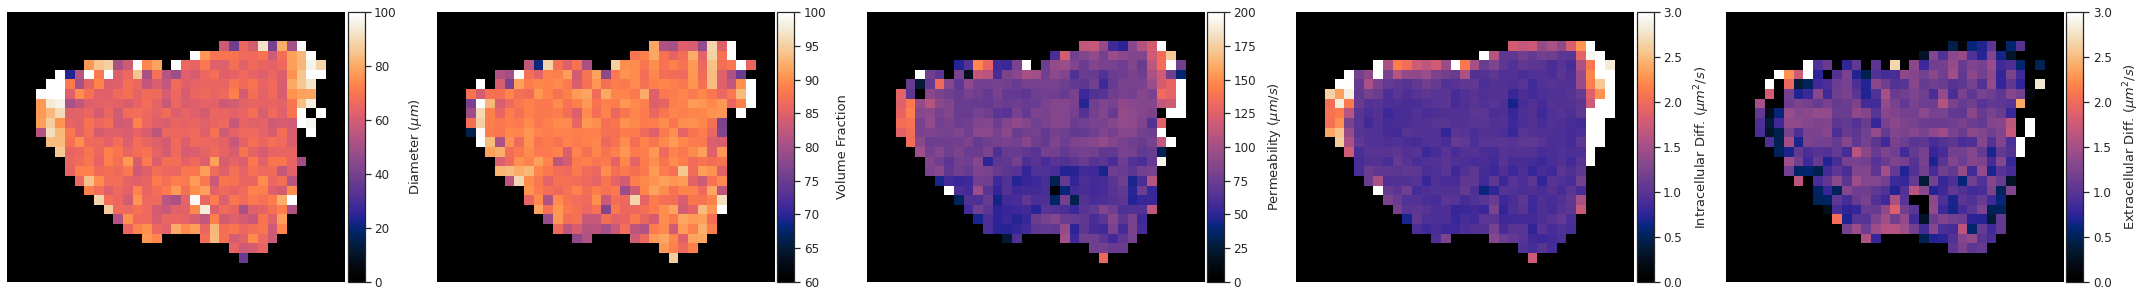

In [159]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import cmasher as cmr

ms_keys = ['Diameter ($\mu m$)', 'Volume Fraction', 'Permeability ($\mu m/s$)', 
           'Intracellular Diff. ($\mu m^2/s$)', 'Extracellular Diff. ($\mu m^2/s$)']
save_name = ['diameter','vf','perm','Din','Dex']
# diameter_fit = np.clip(np.reshape(temp,(64,64,20)),0,100)*mask
# data.shape
minv = [0, 60, 0, 0, 0]
maxv = [100, 100, 200, 3, 3]
min_std = [0, 0, 0, 0, 0]
max_std = [40, 30, 40, 5, 30]

letter = ['a','b','c','d','e']
fig = plt.figure(figsize=(30,5))
for i in range(5):
#     fig = plt.figure(figsize=(10,10))
    
    plt.subplot(1, 5, i+1)#.set_axis_off()
    if i < 3:
        im = plt.imshow(np.clip(fits[params[i]][:,:,10].T,minv[i],maxv[i])[15:43,15:50], cmap = plt.get_cmap('cmr.torch'))
    else:
        im = plt.imshow(np.clip(fits[params[i]][:,:,10].T*0.1,minv[i],maxv[i])[15:43,15:50], cmap = plt.get_cmap('cmr.torch'))
        
#     plt.title('Estimate of %s' % ms_keys[i], fontsize = 12)
    plt.xlabel('(%s)' % letter[i], fontsize = 14)
    plt.axis('off')
#     plt.tick_params(axis='both', which='both', bottom='off', top='off', 
#                     labelbottom='off', right='off', left='off', labelleft='off')
    ax = plt.gca()
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, label = ms_keys[i])
    cbar.ax.tick_params(labelsize=12) 
    cbar.set_label(ms_keys[i], labelpad=10)
    cbar.ax.yaxis.label.set_size(13)
    
plt.tight_layout()
# fig.subplots_adjust(wspace=0.1)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.show()


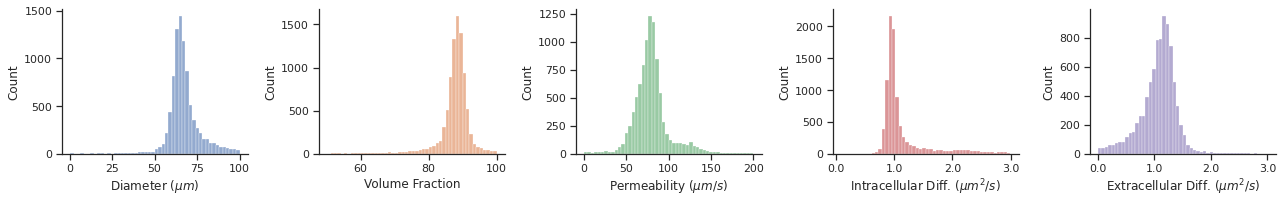

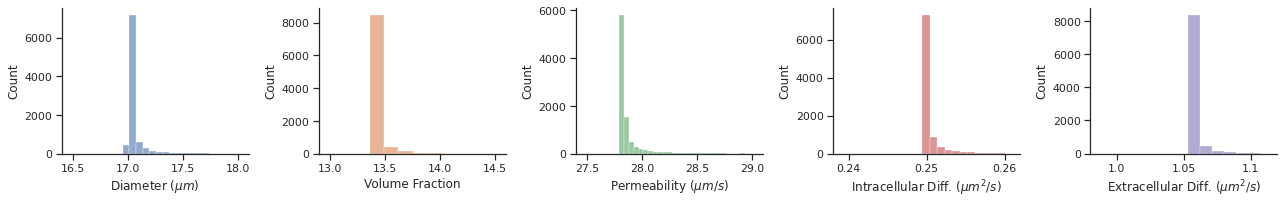

In [161]:
# diameter_fit = np.clip(np.reshape(temp,(64,64,20)),0,100)*mask
# data.shape

import seaborn as sns

minv = [0, 50, 0, 0, 0]
maxv = [100, 100, 200, 30, 30]
min_std = [0, 0, 0, 0, 0]
max_std = [20, 20, 30, 3, 15]
min_std_lim = [16.4, 12.9, 27.4, 0.248, 0.98]
max_std_lim = [18.1, 14.6, 29.1, 0.262, 1.22]

lett = ['a','b','c','d','e']
ms_keys = ['Diameter ($\mu m$)', 'Volume Fraction', 'Permeability ($\mu m/s$)', 
           'Intracellular Diff. ($\mu m^2/s$)', 'Extracellular Diff. ($\mu m^2/s$)']
fig = plt.figure(figsize=(18,3))

color = sns.color_palette(n_colors=5)
sns.set(style="ticks")

for i in range(5):
#     fig = plt.figure(figsize=(5,2))

    plt.subplot(1,5, i+1)
    temp = np.clip(fits[params[i]].flatten(),minv[i],maxv[i])
    temp[temp == minv[i]] = np.nan
    temp[temp == maxv[i]] = np.nan
    temp =  temp[np.logical_not(np.isnan(temp))]
#     temp = (fits[params[i]]*mask).flatten()
#     temp[temp == 0] = np.nan
    weights = np.ones_like(temp)/float(len(temp))

#     plt.hist(temp, bins = 100, range = (minv[i],maxv[i]))
    
    sns.histplot(data=temp,  element="bars",  stat="count", bins=50,  color = color[i], alpha=0.6)

    plt.xlabel('%s' % (ms_keys[i]))
    if i > 2:
        plt.xticks([0.0, 10.0, 20.0, 30.0], [0.0,1.0,2.0,3.0])
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.4)

plt.tight_layout()
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.despine()
plt.savefig('/home/noel/paramter_hist.pdf' , format='pdf', bbox_inches='tight')
plt.show()
# plt.savefig('estimate.png' % num, dpi = 600, format = 'png', bbox_inches='tight')

lett = ['f','g','h','i','j']
fig = plt.figure(figsize=(18,3))
for i in range(5):
#     fig = plt.figure(figsize=(5,2))

    plt.subplot(1,5, i+1)
    temp0 = np.clip(fit_std[params[i]].flatten(),min_std[i],max_std[i])
    temp0[temp0 == 0] = np.nan
    temp0[temp0 == max_std[i]] = np.nan
    temp0 =  temp0[np.logical_not(np.isnan(temp0))]
#     plt.hist(temp0,bins = 50)
    sns.histplot(data=temp0,  element="bars",  stat="count", common_norm=False, bins=50,  color = color[i], alpha=0.6)

    plt.xlim([min_std_lim[i],max_std_lim[i]])

    if i == 3:
        plt.xticks([2.4, 2.5, 2.6], [0.24, 0.25, 0.26])
        plt.xlim([2.38,2.62])
    if i == 4:
        plt.xticks([10,10.5,11],[1.0,1.05,1.1])
        plt.xlim([9.8,11.2])
    plt.xlabel('%s' % (ms_keys[i]))
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.6)

plt.tight_layout()
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.despine()
plt.savefig('/home/noel/paramter_std.pdf' , format='pdf', bbox_inches='tight')
#     plt.ylim([0,10000])
plt.show()
# plt.savefig('CI_interval.png' % num, dpi = 600, format = 'png', bbox_inches='tight')


